In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion,make_pipeline,make_union
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample
from random_classes import GetDummiesTransformer, ColumnSelector

from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df=pd.read_csv('AB_NYC_2019.csv')
subway=pd.read_csv('distance_subway.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
print(df.shape)
print(subway.shape)

(48895, 16)
(48895, 5)


In [4]:
subway.head()

,Unnamed: 0,latitude,longitude,geometry,min_d_subway
0,0,40.64749,-73.97237,POINT (-1214146.661204302 8552426.242393984),475.343641
1,1,40.75362,-73.98377,POINT (-1212970.464925146 8564445.85893997),95.423788
2,2,40.80902,-73.94190,POINT (-1208298.837633305 8569984.556810914),341.415381
3,3,40.68514,-73.95976,POINT (-1212315.368504829 8556434.447034063),425.642989
4,4,40.79851,-73.94399,POINT (-1208688.332608632 8568843.856223075),204.945877


In [5]:
df['subway_d']=subway['min_d_subway']

In [6]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,subway_d
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,475.343641
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,95.423788
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,341.415381
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,425.642989
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,204.945877


In [7]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
subway_d                              0
dtype: int64

# Preprocessing and EDA

Many machine learning algorithms do badly when acting on inputs with missing data. To deal with this, we start by taking a count of missing values in each column.

In [8]:
df[df['last_review'].isnull()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,subway_d
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,341.415381
19,7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaN,NaN,2,249,367.603942
26,8700,Magnifique Suite au N de Manhattan - vue Cloitres,26394,Claude & Sophie,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaN,NaN,1,0,244.404068
36,11452,Clean and Quiet in Brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaN,NaN,1,365,839.664959
38,11943,Country space in the city,45445,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaN,NaN,1,365,218.720487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9,220.252499
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36,488.957233
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27,370.968028
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2,121.626290


The NaN values in the last_review and reviews_per_month columns all occur for examples where no reviews were given in the first place.



In [9]:
df['last_review']=df['last_review'].fillna(0)

In [10]:
df['reviews_per_month']=df['reviews_per_month'].fillna(0)

In [11]:
df.isnull().sum()

id                                 0
name                              16
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
last_review                        0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
subway_d                           0
dtype: int64

In [12]:
df.shape

(48895, 17)

In [13]:
df=df[df['name'].notnull()]

In [14]:
df=df[df['host_name'].notnull()]

In [15]:
df.shape

(48858, 17)

In [16]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,subway_d
count,4.885800e+04,4.885800e+04,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000
mean,1.902335e+07,6.763169e+07,40.728941,-73.952170,152.740309,7.012444,23.273098,1.091124,7.148369,112.801425,481.946840
std,1.098289e+07,7.862389e+07,0.054528,0.046159,240.232386,20.019757,44.549898,1.597270,32.964600,131.610962,863.453950
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.926754
25%,9.475980e+06,7.818669e+06,40.690090,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,207.011507
50%,1.969114e+07,3.079133e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,320.833628
75%,2.915765e+07,1.074344e+08,40.763107,-73.936280,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,478.158527
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,22493.761092


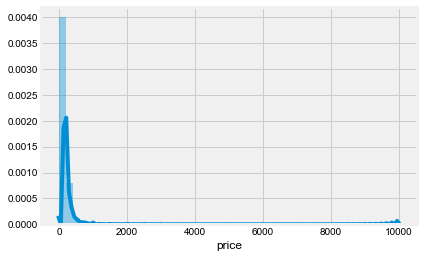

In [17]:

sns.distplot(df['price'])

we can observe that there are prices with 0 in the dataset, this makes no sense so we are not going to considered them

In [18]:
df[df['price']==0]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,subway_d
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28,94.649228
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127,488.100740
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0,398.711150
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0,902.874235
25778,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73,420.014022
25794,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,2019-06-15,4.28,6,176,291.339663
25795,20639792,Contemporary bedroom in brownstone with nice view,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,2019-06-21,4.37,6,232,113.855577
25796,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,2019-06-23,4.35,6,222,214.276431
26259,20933849,the best you can find,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,0,0.00,1,0,59.404668
26841,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,2019-06-22,0.11,6,333,437.333674


In [19]:
df=df[df['price']!=0]

In [20]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,subway_d
count,4.884700e+04,4.884700e+04,48847.000000,48847.000000,48847.000000,48847.000000,48847.000000,48847.000000,48847.000000,48847.000000,48847.000000
mean,1.902300e+07,6.763372e+07,40.728945,-73.952176,152.774705,7.012365,23.270621,1.091014,7.149016,112.799599,481.973923
std,1.098410e+07,7.862959e+07,0.054529,0.046161,240.248498,20.021362,44.550647,1.597200,32.968270,131.615947,863.542067
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.926754
25%,9.475094e+06,7.814734e+06,40.690090,-73.983080,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,207.011587
50%,1.968202e+07,3.079133e+07,40.723080,-73.955690,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,320.828400
75%,2.915833e+07,1.074344e+08,40.763110,-73.936295,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,478.155128
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,22493.761092


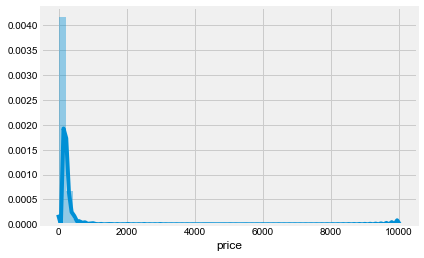

In [21]:
sns.distplot(df['price'])

In [22]:
print(df['price'].value_counts().sort_values(ascending=False))

100     2048
150     2046
50      1531
60      1458
200     1400
        ... 
434        1
894        1
4160       1
659        1
1880       1
Name: price, Length: 673, dtype: int64


In [23]:
df=df[df['price']<1500]

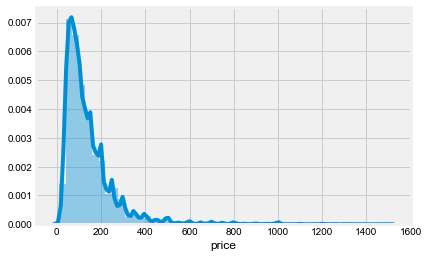

In [24]:
sns.distplot(df['price'])

In [25]:
print(df.shape)
print(df[df['price']>600].shape)

(48682, 17)
(613, 17)


In [26]:
df=df[df['price']<=650]

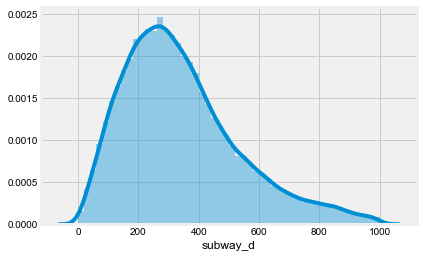

In [27]:
sns.distplot(df[df['subway_d']<1000]['subway_d'])

looking only at the place with distance < 1000 we can determine that the great mayority concentrate between 0 and 400 mts

This could give us valuable information in the future in regards of if closeness to a subway station is a good feature or not for price prediction.

In [28]:
len_h=len(df['host_id'].unique())
shape_df=df.shape[0]
print((len_h/shape_df)*100)
print("Almost 80% of all the rooms are being rented by diferent host -> so host id is not going to be a pertinent feature")

76.75867655305626
Almost 80% of all the rooms are being rented by diferent host -> so host id is not going to be a pertinent feature


In [29]:
df.drop(columns='host_id',inplace=True)
df.drop(columns='id',inplace=True)
df.drop(columns=['name','host_name'],inplace=True)

In [30]:
df.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'subway_d'],
      dtype='object')

# Neighbourhood 

In [31]:
print(df['neighbourhood_group'].unique())


['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


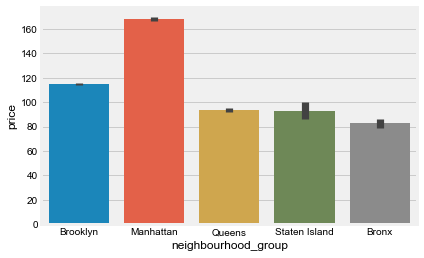

In [32]:
sns.barplot('neighbourhood_group',y='price',data=df)

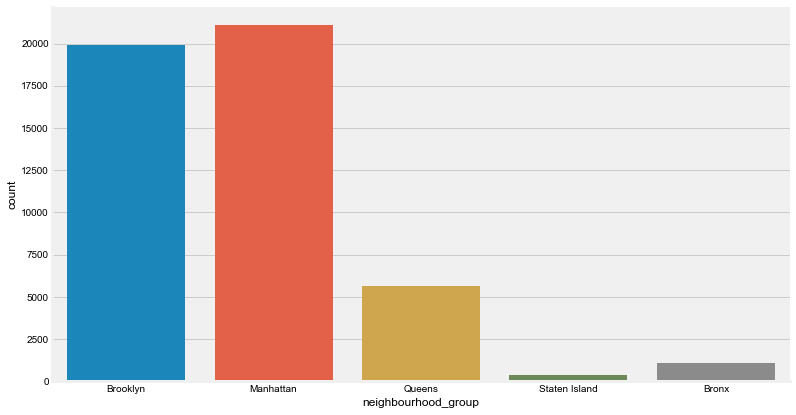

In [33]:
sns.catplot(x='neighbourhood_group',kind='count',data=df)
fig = plt.gcf()
fig.set_size_inches(12, 6)

The graph above give us information about the representation of the differnte neighbourhood groups in the dataset.

We have two great groups and then 1 small one and two practically unrepresentative.

This makes sense if we understand a little about the proportions of each group, manhattan is masive as so is brooklyn.

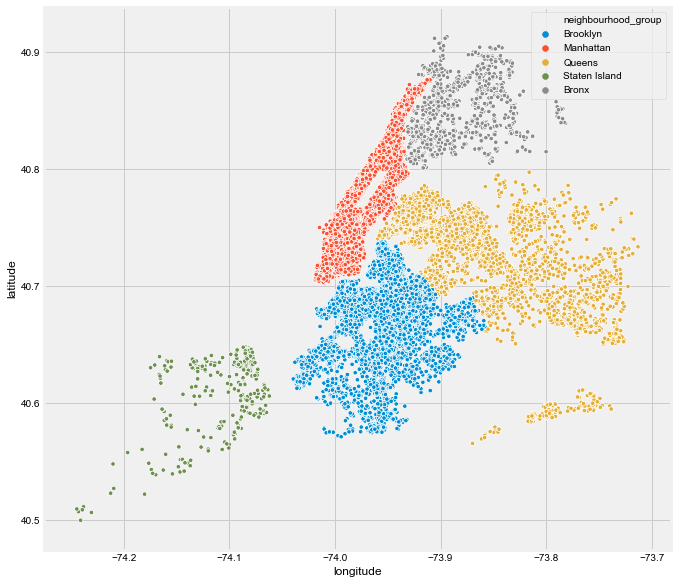

In [34]:
#Review the listings by boroname
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group',s=20, data=df)

In [35]:
#df.drop(columns=['latitude','longitude'],inplace=True)
#is no longer relevante latitude or longitude for the analysis

In [36]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,subway_d
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,475.343641
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,95.423788
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365,341.415381
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,425.642989
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,204.945877


# Room Type

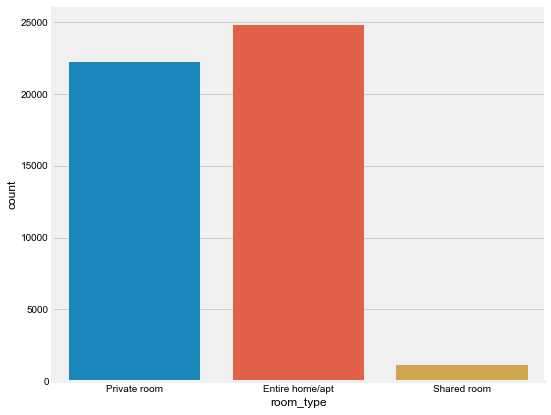

In [37]:
sns.catplot(x='room_type', kind='count' ,data=df)
fig = plt.gcf()
fig.set_size_inches(8, 6)

this makes sense as is the main types of rooms that usually are being rented.
We see that shared rooms is practically non relevant in comparasion with the other two types

In [38]:
#by neighbourhood group
df.groupby(['neighbourhood_group','room_type'])['room_type'].count()

neighbourhood_group  room_type      
Bronx                Entire home/apt      376
                     Private room         649
                     Shared room           58
Brooklyn             Entire home/apt     9444
                     Private room       10088
                     Shared room          410
Manhattan            Entire home/apt    12732
                     Private room        7902
                     Shared room          477
Queens               Entire home/apt     2085
                     Private room        3363
                     Shared room          195
Staten Island        Entire home/apt      171
                     Private room         188
                     Shared room            9
Name: room_type, dtype: int64

# Minimum Nights

In [39]:
df['minimum_nights'].describe()

count    48147.000000
mean         6.954473
std         19.824792
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

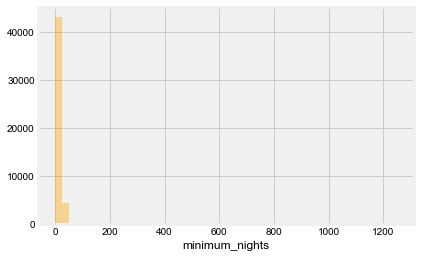

In [40]:
sns.distplot(df['minimum_nights'], rug=False, kde=False, color="orange")


# Number of Reviews

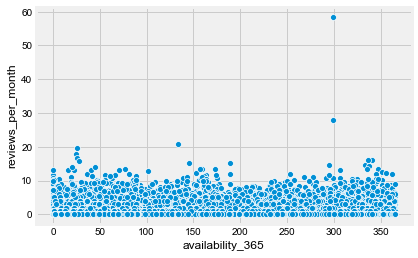

In [41]:
sns.scatterplot(x=df['availability_365'], y=df['reviews_per_month'])

one of the first analysis that one could make is try to look if there is a relationship between apt that are available all year long and the number of reviews per month

It is apparent that there is at least no linear correlation

# Availability 365

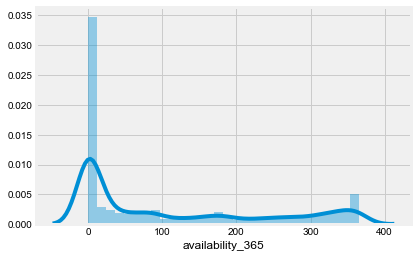

In [42]:
sns.distplot(df['availability_365'])

This distribution is highly skewed towards the low and high end. 

The dataset contains a hiuge number of properties that are available only for a couple of days each year, and a decent number that are available for > 300 days.

In [43]:
df.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,subway_d
latitude,1.000000,0.085750,0.067036,0.025917,-0.014519,-0.018258,0.018952,-0.012135,-0.199818
longitude,0.085750,1.000000,-0.284095,-0.064291,0.057257,0.137532,-0.115362,0.088011,0.113942
price,0.067036,-0.284095,1.000000,0.022253,-0.050393,-0.047984,0.150537,0.101969,-0.081033
minimum_nights,0.025917,-0.064291,0.022253,1.000000,-0.081574,-0.127492,0.131847,0.145799,-0.026830
number_of_reviews,-0.014519,0.057257,-0.050393,-0.081574,1.000000,0.588806,-0.072175,0.176246,0.042975
reviews_per_month,-0.018258,0.137532,-0.047984,-0.127492,0.588806,1.000000,-0.046667,0.167937,0.101483
calculated_host_listings_count,0.018952,-0.115362,0.150537,0.131847,-0.072175,-0.046667,1.000000,0.226934,-0.035228
availability_365,-0.012135,0.088011,0.101969,0.145799,0.176246,0.167937,0.226934,1.000000,0.099931
subway_d,-0.199818,0.113942,-0.081033,-0.026830,0.042975,0.101483,-0.035228,0.099931,1.000000


There don't appear to exist obvious, strong correlations between these variables.

However, the number of reviews per month is fairly (40%) correlated with the total number of reviews and the the total number of reviews is correlated (at 30%) with the availability of the property. Both of these correlations make sense.

It's also interesting that the longitude is anticorrelated (at 20%) with the price. That also makes sense - property in the Bronx and in Queens is cheaper than Manhattan and Brooklyn.

In [44]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,subway_d
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,475.343641
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,95.423788
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365,341.415381
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,425.642989
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,204.945877


In [45]:
df=df.drop(columns='last_review')

In [46]:
X=df.drop(columns='price')
y=df['price']

In [48]:
X.dtypes

neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
subway_d                          float64
dtype: object

# 1.8 Train-test split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
print('training X {}'.format(X_train.shape))
print('training y: {}'.format(y_train.shape))
print('test X: {}'.format(X_test.shape))
print('test y : {}'.format(y_test.shape))

training X (38517, 11)
training y: (38517,)
test X: (9630, 11)
test y : (9630,)


In [53]:
X.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'subway_d'],
      dtype='object')

In [51]:
dummies_pipe = Pipeline([('dummies',GetDummiesTransformer(['neighbourhood_group','neighbourhood','room_type']))])

In [54]:
pipe_num = Pipeline([
    #('kbest',kbest),
    ('columnselector',ColumnSelector(['latitude', 'longitude',
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'subway_d']))])
#     ('scale', StandardScaler()),
#     ('classifier', None)

In [57]:
union = make_union(pipe_num,dummies_pipe)


In [60]:
seed=42

In [63]:
union = make_union(pipe_num,dummies_pipe)
pipe_master = Pipeline([
    ('union', union),
    ('scale', StandardScaler()),
    ('regressor', None)
])

grid=[dict(regressor__n_estimators=[600],
             regressor__random_state=[seed],
             regressor__min_samples_split=[2,3],
             regressor__min_samples_leaf=[10,50],
             regressor__bootstrap=[True,False],
             regressor__max_depth=[5,6],
             regressor=[RandomForestRegressor()])]



gs = GridSearchCV(pipe_master, grid, scoring='r2',verbose=-3,
                  cv=5,return_train_score=False,n_jobs=-1).fit(X_train, y_train)
gs.fit(X_train, y_train).best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 43.8min finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 44.3min finished


{'regressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False),
 'regressor__bootstrap': True,
 'regressor__max_depth': 6,
 'regressor__min_samples_leaf': 10,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 600,
 'regressor__random_state': 42}

In [67]:
def print_metrics(y_real,y_pred):
    print('MSE:', round(mean_squared_error(y_real, y_pred),6))
    print('RMSE:', round(np.sqrt(mean_squared_error(y_real, y_pred)),6))
    print('R2:', round(r2_score(y_real, y_pred),4))

In [68]:
y_pred=gs.predict(X_test)

In [70]:
y_pred_tr=gs.predict(X_train)

In [71]:
print_metrics(y_train,y_pred_tr)

MSE: 4967.164395
RMSE: 70.478113
R2: 0.4628


In [69]:
print_metrics(y_test,y_pred)

MSE: 5087.087734
RMSE: 71.323823
R2: 0.4304
